In [11]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore")
plt.style.use("default")
from pathlib import Path
import cftime
import os, sys
import seaborn as sns
import cartopy
import cartopy.feature as cpf
from global_land_mask import globe
import CMIP6_light_map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import rioxarray
from matplotlib import cm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.dates as mdates
import global_land_mask
from tqdm.notebook import trange, tqdm

sys.path.append("../CMIP6_downscale/")
from CMIP6_ridgeplot import CMIP6_ridgeplot
from xclim import ensembles
from CMIP6_IO import CMIP6_IO
from CMIP6_config import Config_albedo

In [12]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)


def get_LME_records_plot():
    lme_file = "gs://actea-shared/Shapefiles/LME66_180/LME66_180.shp"
    return gpd.read_file(lme_file)


def create_colors(N):
    color = iter(cm.tab20b(np.linspace(0, 1, N)))
    return [next(color) for c in range(N)]


def get_data_within_LME(ds, var_name, LME, create_maps):
    # Extract the polygon defining the boundaries of the LME
    print(f"Working on LME: {LME}")

    if LME == "Northern Bering - Chukchi Seas":
        shdf = get_LME_records_plot()
    elif LME == "Barents Sea":
        shdf = get_LME_records()
    else:
        raise Exception(f"Unable to parse LME {LME}")

    shdf_sel = shdf[shdf["LME_NAME"] == LME]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    if var_name not in ["TOZ"]:
        ds = ds.rename({"x": "lon", "y": "lat"})
    ds = ds.rio.write_crs(4326)

    ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
    ds.rio.write_crs(4326, inplace=True)

    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    if "x" in ds.dims:
        clipped = clipped.rename({"x": "lon", "y": "lat"})
    return clipped

In [13]:
def convert_to_180(ds, LME, var_name):
    print(ds)
    # We need to rename and reorganize the dimensions and names for spatial
    # coordinates to work with geopandas.
    if var_name == "TOZ":
        ds = ds.assign_coords(lat=ds.lat.values, lon=ds.lon.values)
    else:
        ds = ds.assign_coords(lat=ds.lat[:, 0].values, lon=ds.lon[0, :].values)
    if LME == "Northern Bering - Chukchi Seas":
        ds = (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby("lon")

    return ds


def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:
        time_objects = ds.indexes["time"].to_datetimeindex()
        ds = ds.assign_coords({"time": time_objects})
        ds = xr.decode_cf(ds)

    return ds


def get_area_averaged_ds(
    model,
    experiment_id,
    ds,
    var_name,
    LME,
    create_maps,
    outfile_name,
    frequency,
    start_time,
    end_time,
):
    # Frequency of smoothing the plots. This is the number of years to smooth over
    # if frequency is Annual.
    roll_frequency = 1

    ds = convert_to_180(ds, LME, var_name)

    ds = ds.sel(time=slice(start_time, end_time))
    ds = convert_time(ds)
    if var_name in ["tas"]:
        ds = xr.where(ds > 100, ds - 273.15, ds)

    # Convert from kg/m-3 to mg/m-3
    # if var_name in ["chl"]:
    #  ds[var_name]=ds[var_name]/1.0e6

    ds_lme = get_data_within_LME(ds, var_name, LME, create_maps)
    outfile = f"Figures/{var_name}_{experiment_id}_ridgeplot_{LME}.png"
    if Path(outfile).exists():
        Path(outfile).unlink()
    CMIP6_ridgeplot.ridgeplot(
        var_name, None, outfile, glorys=False, depth_threshold=None, ds=ds_lme
    )

    ds = ds_lme.mean({"lat", "lon"}, skipna=True)

    if var_name in ["TOZ"]:
        ds = ds.assign(TOZ_std=ds_lme[var_name].std({"lat", "lon"}))
    dfstd = ds[f"{var_name}_stdev"].to_dataframe().dropna().reset_index()
    dfmean = ds[f"{var_name}_mean"].to_dataframe().dropna().reset_index()

    df = dfmean
    df["mean"] = dfmean[f"{var_name}_mean"]
    df["std"] = dfstd[f"{var_name}_stdev"]

    df = df.reset_index()
    df = df.set_index("time")

    df = df.resample(frequency).mean()
    df["model_name"] = model
    df["LME"] = LME
    df["roll_mean"] = df["mean"].rolling(roll_frequency).mean(skipna=True)
    df["roll_std"] = df["std"].rolling(roll_frequency).mean(skipna=True)

    df["model_scenario"] = experiment_id
    unique = "{}_{}".format(model, experiment_id)
    df["unique"] = unique

    model_info = {}
    model_info["model_name"] = model
    model_info["model_scenario"] = experiment_id
    model_info["model_var"] = var_name
    model_info["LME"] = LME

    return df, model_info

In [14]:
def calculate_velocity(df_uas: pd.DataFrame, df_vas: pd.DataFrame):
    print("calculate_velocity")

    u_ssp245 = df_uas["ssp245"]
    u_ssp585 = df_uas["ssp585"]

    v_ssp245 = df_vas["ssp245"]
    v_ssp585 = df_vas["ssp585"]

    df_ssp245 = u_ssp245
    df_ssp585 = u_ssp585

    df_ssp245["mean"] = np.sqrt(
        np.power(u_ssp245["mean"], 2) + np.power(v_ssp245["mean"], 2)
    )
    df_ssp245["std"] = np.sqrt(
        np.power(u_ssp245["std"], 2) + np.power(v_ssp245["std"], 2)
    )

    df_ssp585["mean"] = np.sqrt(
        np.power(u_ssp585["mean"], 2) + np.power(v_ssp585["mean"], 2)
    )
    df_ssp585["std"] = np.sqrt(
        np.power(u_ssp585["std"], 2) + np.power(v_ssp585["std"], 2)
    )

    df_ssp585 = df_ssp585.reset_index()
    df_ssp245 = df_ssp245.reset_index()

    return df_ssp245, df_ssp585


def create_timeseries_for_lme(
    varname: str, df: [pd.DataFrame], LME: str, stored_uas=None
):
    if stored_uas is None:
        df_ssp245 = df["ssp245"]
        df_ssp585 = df["ssp585"]
    else:
        varname = "velocity"
        df_ssp245, df_ssp585 = calculate_velocity(stored_uas, df)

    df_ssp245["date"] = df_ssp245.index
    df_ssp585["date"] = df_ssp585.index
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.3)
    f = plt.figure(figsize=(16, 16))
    gs = f.add_gridspec(2, 1)
    ax = f.add_subplot(gs[0, 0])

    sns.set_palette(["#8172B3", "#64B5CD"])
    legend_on = True if varname == "tas" else False

    b = sns.lineplot(
        ax=ax,
        data=df_ssp245,
        x=df_ssp245["date"],
        y=df_ssp245["roll_mean"],
        hue=df_ssp245["model_scenario"],
        palette=["#8172B3"],
        alpha=0.95,
        ci=95,
        linewidth=5,
        legend=legend_on,
    )

    b = sns.lineplot(
        ax=ax,
        data=df_ssp585,
        x=df_ssp585["date"],
        y=df_ssp585["roll_mean"],
        hue=df_ssp585["model_scenario"],
        palette=["#64B5CD"],
        alpha=0.95,
        ci=95,
        linewidth=5,
        legend=legend_on,
    )

    cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    ax.fill_between(
        df_ssp245["date"],
        df_ssp245["roll_mean"] - df_ssp245["roll_std"],
        df_ssp245["roll_mean"] + df_ssp245["roll_std"],
        color=cycle_colors[0],
        alpha=0.2,
    )

    ax.fill_between(
        df_ssp585["date"],
        df_ssp585["roll_mean"] - df_ssp585["roll_std"],
        df_ssp585["roll_mean"] + df_ssp585["roll_std"],
        color=cycle_colors[1],
        alpha=0.2,
    )

    b.tick_params(labelsize=30)
    b.set_xlabel("", fontsize=30)
    b.set_ylabel("", fontsize=30)

    if varname in ["sithick", "siconc", "sisnconc", "sisnconc"]:
        plt.ylim(0.0, None)

    if varname == "tas":
        plt.legend(loc="upper left", frameon=False, fontsize=32)

    ax.xaxis.set_major_locator(mdates.YearLocator(base=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=-90)

    if not os.path.exists("Figures"):
        os.makedirs("Figures")
    plotfile = f"Figures/CMIP6_lightpaper_{varname}_{LME}.png"
    print(f"Created figure {plotfile}")
    plt.savefig(plotfile, dpi=300, bbox_inches="tight")
    plt.show()

[CMIP6_IO] Opening file actea-shared/light/ssp585/TOZ_ssp585.nc
<xarray.Dataset>
Dimensions:  (time: 1800, lat: 48, lon: 144)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat      (lat) float32 0.9474 2.842 4.737 6.632 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    TOZ      (time, lat, lon) float32 ...
Working on LME: Barents Sea
Created dataframe for 1993-2012:              month  spatial_ref          TOZ
count  3120.000000       3120.0  1764.000000
mean      6.500000          0.0   347.449341
std       3.452606          0.0    51.744919
min       1.000000          0.0   275.933502
25%       3.750000          0.0   297.410767
50%       6.500000          0.0   341.869019
75%       9.250000          0.0   397.910645
max      12.000000          0.0   434.979187
Created dataframe for 2012-2020:              month  spatial_ref          TOZ
count  3120.000000       3120.0  

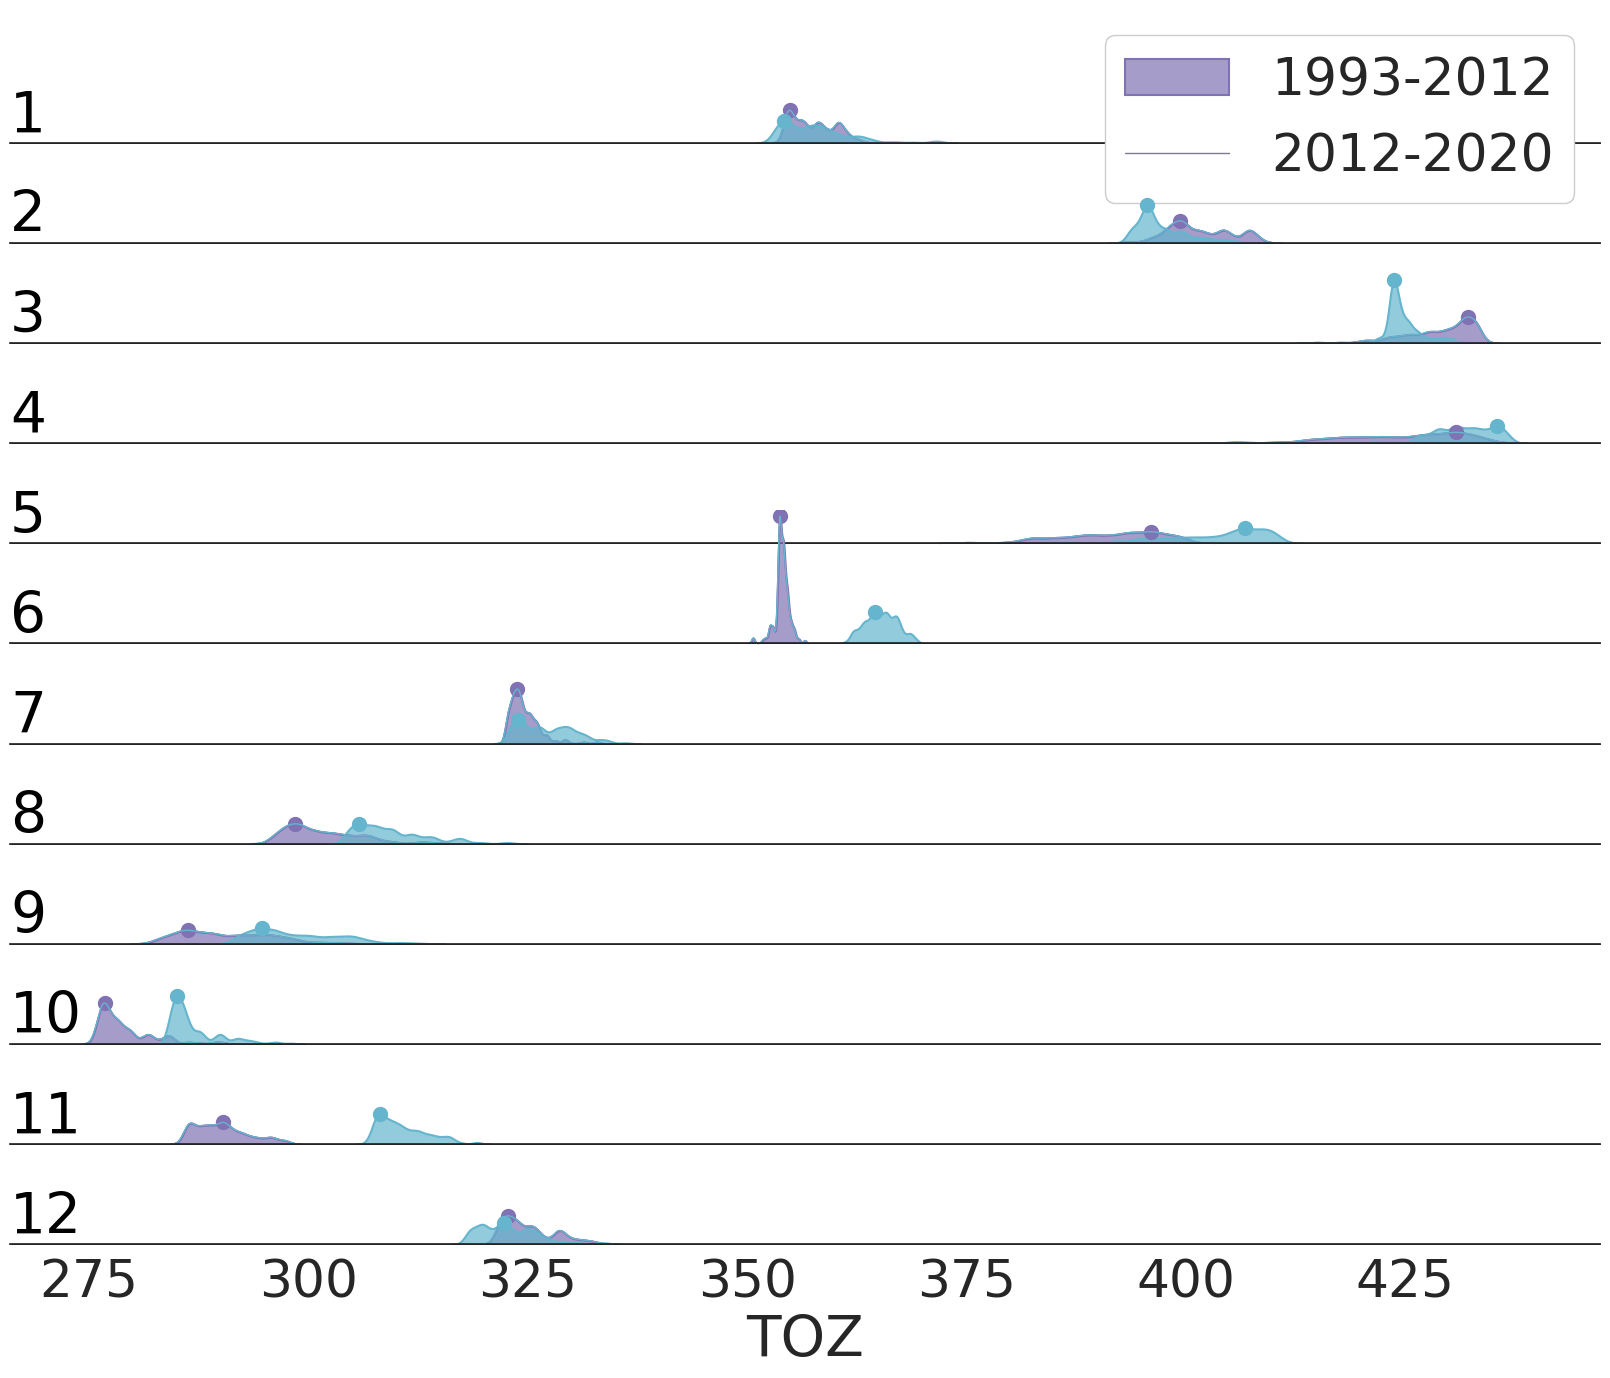

KeyError: 'TOZ_stdev'

In [16]:
%%time
experiment_ids = ["ssp245", "ssp585"]
frequency = "A"

# Create objects to reuse functionality to open files on Google Cloud storage
config = Config_albedo()
create_maps = False

period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

ds_var_names = [
    "prw",
    "clt",
    "chl",
    "sithick",
    "siconc",
    "sisnthick",
    "sisnconc",
    "tas",
    "tos",
]
#      "uas",
#      "vas"]

ds_var_names = ["TOZ"]

LMES = ["Northern Bering - Chukchi Seas", "Barents Sea"]
toz_list = []
for LME in LMES:
    stored_uas = None
    for varname in ds_var_names:
        all_dfs = {}

        for experiment_id in experiment_ids:
            all_ds = []
            ens_stats = None

            io = CMIP6_IO()
            direc = "light"
            if varname == "TOZ":
                ensemble_filename_stats = (
                    f"light/{experiment_id}/TOZ_{experiment_id}.nc"
                )
            else:
                ensemble_filename_stats = io.format_netcdf_filename(
                    direc, "ensemble", "", experiment_id, varname
                )

            ens_stats = io.open_dataset_on_gs(ensemble_filename_stats)

            outfile_name = ensemble_filename_stats.replace(".nc", f"_{LME}.png")

            df, models_dict = get_area_averaged_ds(
                "ensemble",
                experiment_id,
                ens_stats,
                varname,
                LME,
                create_maps,
                outfile_name,
                frequency,
                start_time,
                end_time,
            )

            all_dfs[experiment_id] = df

        if varname == "uas":
            print("Storing uas", stored_uas)
            stored_uas = all_dfs.copy()

        create_timeseries_for_lme(varname, all_dfs, LME, stored_uas=stored_uas)
    stored_uas = None